# Combining ionChem with ElSpec
## Goal: run ELSpec, load produced output, run ionChem, feed produced output to ElSpec

In [3]:
direc = '/Users/ost051/Documents/PhD/ELSPEC-2022/test/'
file = 'ElSpec-iqt_IC_'
iteration = 0

In [4]:
import scipy.io as spio
from scipy.integrate import solve_ivp
from scipy.interpolate import PchipInterpolator
import import_ipynb
import ionChem
import numpy as np
import matplotlib.pyplot as plt
import loadMSIS


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

if True:
    file_i = file + str(iteration)
    f = direc + file_i
    mat = loadmat(f)
    con = mat["ElSpecOut"]

    ne = con["ne"]
    n_model = con["iri"]
    [Tn,Ti,Te,nN2,nO2,nO,nAr,nNOp,nO2p,nOp] = n_model[:, :, 0].T
    [nNOp,nO2p,nOp] = n_model[:, 7:, 0].T/np.sum(n_model[:, 7:, 0], axis = 1)*ne[:, 0]
    
    temp = n_model[:, :3, :].T
    ts = con["ts"]
    te = con["te"] - ts[0]
    ts = ts - ts[0]
    e_prod = con["q"].T
    
    msis_model = loadMSIS.loadMSIS_new('/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis.rtf')
    nH = msis_model[4]
    
    def stepped_prod_t(prod, t):
        """
        returns the production according to the ELSPEC model
        of any species where prod is defined
        at arbitrary times
        using the last ts from ELSPEC
        """
        if t<ts[0]:
            return 0
        if t >te[-1]:
            return 0
        else:
            i_max_ts = len(ts[ts<=t])-1
            prod_t = prod[i_max_ts]
            return prod_t
    
    chemistry_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/' + \
                        'Meta-data/Reaction rates.txt'
    z_model = con["h"]
    
    model = ionChem.ionChem(chemistry_config, z_model)
    
    #assign densities
    model.N2.density  = nN2
    model.O2.density  = nO2
    model.O.density   = nO
    model.NOp.density = nNOp
    model.O2p.density = nO2p
    model.Op.density  = nOp
    
    model.Np.density  = model.N2.density*0
    model.N2p.density = model.N2.density*0
    model.N.density   = model.N2.density*0
    model.NO.density  = model.N2.density*0
    model.H.density   = np.exp(PchipInterpolator(msis_model[0][1:-3]/1e3, np.log(nH[1:-3]))(con["h"]))
    model.Hp.density  = model.N2.density*0
    
    #model.e.density = np.sum([nNOp,nO2p,nOp,model.N2p.density], axis = 0)
    
    model.e.density = con["ne"][:, 0]
    
    model.check_chargeNeutrality()
    
    #assign production (unused?)
    for c in model.all_species:
        c.prod = e_prod *0
    
    #model.e.prod   = e_prod
    Op_prod  = e_prod * 0.56 * model.O.density  / \
        (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    O2p_prod = e_prod * 1.00 * model.O2.density / \
        (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    N2p_prod = e_prod * 0.92 * model.N2.density / \
        (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    
    
    #create smooth function for production
    t = np.arange(0, te[-1], 0.01)
    
    stepf = np.array([stepped_prod_t(e_prod, i) for i in t])
    e_prod_smooth = PchipInterpolator(t, stepf)
    
    stepf = np.array([stepped_prod_t(Op_prod, i) for i in t])
    Op_prod_smooth = PchipInterpolator(t, stepf)
    
    stepf = np.array([stepped_prod_t(O2p_prod, i) for i in t])
    O2p_prod_smooth = PchipInterpolator(t, stepf)

    stepf = np.array([stepped_prod_t(N2p_prod, i) for i in t])
    N2p_prod_smooth = PchipInterpolator(t, stepf)
    
    #zero function for species that dont feel production 
    def zerof(t):
        try:
            some_object_iterator = iter(t)
            return np.zeros(len(t), len(z_model))
        except TypeError as te:
            return np.zeros(len(z_model))
    
    #save production function as array, in order of species
    prodMat = np.array([e_prod_smooth, 
                        zerof, 
                        Op_prod_smooth, 
                        zerof, 
                        O2p_prod_smooth, 
                        zerof, 
                        zerof, 
                        zerof, 
                        N2p_prod_smooth, 
                        zerof, 
                        zerof, 
                        zerof,
                        zerof])

    #new way to do ionospheric chemistry
    #1. take all info from reaction (reaction rate, constituents)
    ode_mat = np.zeros((len(model.all_reactions), len(model.all_species)), dtype = 'object')
    rrate = np.array([np.array([r.r_rate_t(*t) for r in model.all_reactions]) for t in temp])
    
    for r in model.all_reactions:
        e = r.educts_ID
        p = r.products_ID
        ode_mat[r.r_ID, e[0]] = np.array([r.r_ID, -1, *e])
        ode_mat[r.r_ID, e[1]] = np.array([r.r_ID, -1, *e])
        ode_mat[r.r_ID, p[0]] = np.array([r.r_ID,  1, *e])
        try:
            ode_mat[r.r_ID, p[1]] = np.array([r.r_ID,  1, *e])
            if p[1] == p[0]: ode_mat[r.r_ID, p[0]] = np.array([r.r_ID,  2, *e])
        except IndexError:
            print('This is a useless statement. It is necessary. ' + \
                  'It could be replaced with another statement. Do what you wish with this information.')
    
    #2. produce raw DG from 1., excluding all terms that are 0 anyways.
    ode_raw = np.empty(len(model.all_species), dtype = 'object')
    for i in model.all_species:
    #    print(np.array([o for o in ode_mat[:, i.c_ID] if type(o)!= int]))
        ode_raw[i.c_ID] = np.array([o for o in ode_mat[:, i.c_ID] if type(o) != int])
        
    #3. produce DG with only relevant terms
    def fun(t, n, h):
        if t >= ts[0] and t<=te[-1]:
            k = len(ts[ts<=t])-1
        else:
            print(t)
            raise RuntimeError
            
        dndt = np.array([np.sum(((rrate[k, ode_raw[i.c_ID][:, 0], h].T  *   ode_raw[i.c_ID][:, 1] ).T\
                                    * n[ode_raw[i.c_ID][:, 2]]          * n[ode_raw[i.c_ID][:, 3]]   \
                                ), axis = 0) \
                        + prodMat[i.c_ID](t)[h]\
                        for i in model.all_species])
        return dndt
    
    def ic():
        res = np.empty(model.n_heights, dtype = 'object')
        
        for h in range(model.n_heights):
            n = np.array([c.density[h] for c in model.all_species])
            res[h] = solve_ivp(fun, (ts[0], te[-1]), n, method='BDF',vectorized=False, args = [h], \
                               t_eval = ts, max_step = 0.0444)
    #        res[h] = solve_ivp(fun, (ts[0], te[-1]), n, method='BDF',vectorized=False, args = [h],
   #                           t_eval = np.arange(0, te[-1], 0.01), max_step = 0.0444)
            #for j, c in enumerate(model.all_species):
            #    c.density[h] = res[h].y[j, -1]           #replaced by below code:
        
        new_densities = np.array([alt.y[:, -1] for alt in res]).T
        #return new_densities
        return res
    
    res = ic()
    
    #check charge nuetrality!!
    [e,O,Op,O2,O2p,N,Np,N2,N2p,NO,NOp,H,Hp] = np.array([r.y for r in res]).swapaxes(0, 1)

    a = np.sum(np.array([Op, O2p, Np, N2p, NOp, Hp]), axis = 0)
    print(a-e)    

    for h, i in enumerate(res):
        for c in model.all_species:
            plt.figure()
            plt.plot(i.t, i.y[c.c_ID, :], label = c.name)
            if c == model.e  : plt.plot(ts, con["ne" ][h, :], label = 'ElSpec ne')
            if c == model.N2 : plt.plot(ts, con["iri"][h, 3], label = 'ElSpec N2')
            if c == model.O2 : plt.plot(ts, con["iri"][h, 4], label = 'ElSpec O2')
            if c == model.O  : plt.plot(ts, con["iri"][h, 5], label = 'ElSpec O ')
            if c == model.NOp: plt.plot(ts, con["iri"][h, 7], label = 'ElSpec NOp')
            if c == model.O2p: plt.plot(ts, con["iri"][h, 8], label = 'ElSpec O2p')
            if c == model.Op : plt.plot(ts, con["iri"][h, 9], label = 'ElSpec Op ')
            plt.legend(loc = 2)
            plt.yscale('log')
            plt.xlabel('Time [s]')
            plt.ylabel('Density [m-3]')
            plt.title(c.name + ' Density')
            ax2 = plt.gca().twinx()
            ax2.plot(ts, e_prod[:, 0], '.', color = 'green', label = 'q_e')
            ax2.set_yscale('log')
            ax2.legend(loc = 1)
            ax2.set_ylabel('Electron production [m-3s-1]')
            #for t in ts: plt.axvline(t, alpha = 0.1)
        break
        
    elspec_iri_ICsorted = np.array([r.y for r in res])

    eff_rr = (rrate.T[:, 0, :]*elspec_iri_ICsorted[:, 10, :] + \
              rrate.T[:, 1, :]*elspec_iri_ICsorted[:, 4 , :] + \
              rrate.T[:, 2, :]*elspec_iri_ICsorted[:, 6 , :]   ) / elspec_iri_ICsorted[:, 0, :]
    
    
    [Tn,Ti,Te,nN2,nO2,nO,nAr,nNOp,nO2p,nOp] = n_model.swapaxes(0, 1)
    [e,O,Op,O2,O2p,N,Np,N2,N2p,NO,NOp,H,Hp] = elspec_iri_ICsorted.swapaxes(0, 1)
    elspec_iri_sorted = np.array([Tn,Ti,Te,nN2,nO2,nO,nAr,NOp,O2p,Op]).swapaxes(0, 1)

    mdict = {"elspec_iri_sorted": elspec_iri_sorted, "eff_rr": eff_rr}
    spio.savemat(direc + 'IC_' + str(iteration) + '.mat', mdict)
    
    d_effrr = con["alpha"] - eff_rr
    
    plt.figure()
    plt.plot(ts, np.abs(d_effrr[0, :]), label = 'd_alpha')
    plt.plot(ts, eff_rr[0, :], label = 'alpha')
    plt.xlabel('Time [s]')
    plt.ylabel('Eff. Recombination Rate [m3s-1]')
    plt.yscale('log')
    plt.legend()
    plt.title('Eff.Rec.Rate and Difference from last Iteratrion')

    h = 20
    [re,rO,rOp,rO2,rO2p,rN,rNp,rN2,rN2p,rNO,rNOp,rH,rHp] = [e,O,Op,O2,O2p,N,Np,N2,N2p,NO,NOp,H,Hp]/e
    plt.figure()
    plt.stackplot(ts, rOp[h],rO2p[h],rNp[h],rN2p[h],rNOp[h],rHp[h], \
                  labels = ['O+', 'O2+', 'N+', 'N2+', 'NO+', 'H+'])
    plt.xlabel('Time [s]')
    plt.ylabel('Ratio of Charged Species')
    plt.legend(loc = 2)
    plt.title('Charged Species Stackplot at height index ' + str(h))
    
    
    #check charge nuetrality!!
    sum_charged = np.sum(np.array([Op, O2p, Np, N2p, NOp, Hp]), axis = 0)
    r = np.abs(a-e)
    r.shape
    plt.figure()
    pm = plt.pcolor(ts, z_model, r/e)
    plt.gcf().colorbar(pm)
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    plt.title('Relative Charge imabalance $(n_{I^+} - n_{e^-})/n_{e^-}$')

    plt.figure()
    pc = plt.pcolor(ts, z_model, eff_rr, label = 'alpha')
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    plt.legend()
    #plt.tight_layout()
    plt.colorbar(pc)
    plt.title('Effective Recombination rate [m3s-1]')
    
    import matplotlib as mpl
    plt.figure()
    pc = plt.pcolor(ts, z_model, d_effrr, norm=mpl.colors.CenteredNorm(),
                    label = 'alpha', cmap = 'RdBu')
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    #plt.tight_layout()
    plt.colorbar(pc)
    plt.title('Deviation from previous eff. rec. rate [m3s-1]')

/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_72804/2377780665.py:27: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_72804/2377780665.py:38: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
<string>:46: RuntimeWarning: invalid value encountered in divide
<string>:48: RuntimeWarning: invalid value encountered in divide


KeyboardInterrupt: 

(95.0, 150.0)

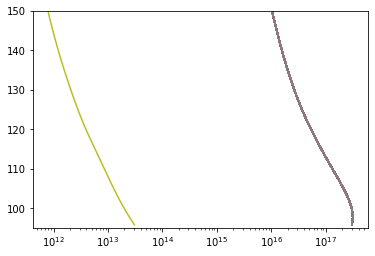

In [26]:
plt.figure()
plt.plot(nO, con["h"])
plt.plot(model.H.density, con["h"])
#plt.plot(nH[1:-3], msis_model[0][1:-3]/1e3)
plt.xscale('log')
plt.ylim((95, 150))



In [11]:
model.H.density   = np.exp(PchipInterpolator(msis_model[0][1:-3], np.log(nH[1:-3]))(con["h"]))


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_71914/3682476831.py:1: RuntimeWarning: overflow encountered in exp
  model.H.density   = np.exp(PchipInterpolator(msis_model[0][1:-3], np.log(nH[1:-3]))(con["h"]))


In [15]:
ode_mat[-2]
ode_raw[-1]

array([[11,  1,  2, 11],
       [16, -1, 12,  1],
       [20,  1,  6, 11]])

Text(0.5, 1.0, 'Charged Species Stackplot at height index 60')

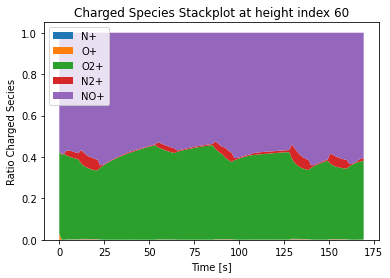

In [3]:
    h = 60
    [re,rO,rOp,rO2,rO2p,rN,rNp,rN2,rN2p,rNO,rNOp] = [e,O,Op,O2,O2p,N,Np,N2,N2p,NO,NOp]/e
    plt.figure()
    plt.stackplot(ts,rNp[h], rOp[h],rO2p[h],rN2p[h],rNOp[h], labels = ['N+', 'O+', 'O2+', 'N2+', 'NO+'])
    plt.xlabel('Time [s]')
    plt.ylabel('Ratio Charged Secies')
    plt.legend(loc = 2)
    plt.title('Charged Species Stackplot at height index ' + str(h))

Text(0.5, 1.0, 'Charged Species Stackplot at height index 60')

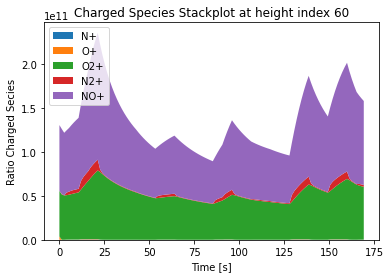

In [4]:
    h = 60
    [re,rO,rOp,rO2,rO2p,rN,rNp,rN2,rN2p,rNO,rNOp] = [e,O,Op,O2,O2p,N,Np,N2,N2p,NO,NOp]/e
    plt.figure()
    plt.stackplot(ts,Np[h], Op[h],O2p[h],N2p[h],NOp[h], labels = ['N+', 'O+', 'O2+', 'N2+', 'NO+'])
    plt.xlabel('Time [s]')
    plt.ylabel('Ratio Charged Secies')
    plt.legend(loc = 2)
    plt.title('Charged Species Stackplot at height index ' + str(h))

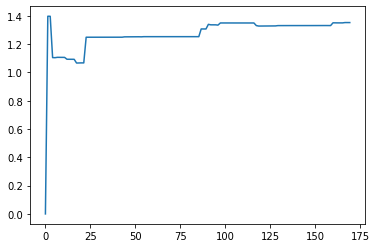

In [5]:
plt.figure()
plt.plot(ts, r[20])

95.85472385504806


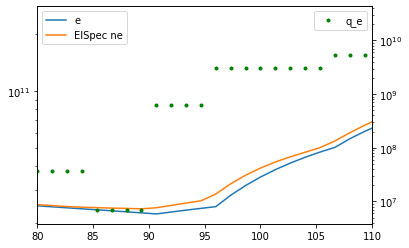

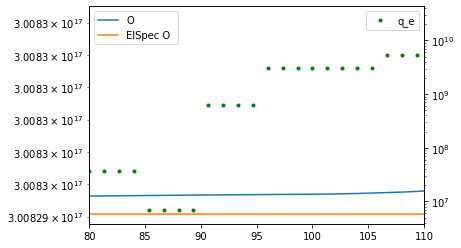

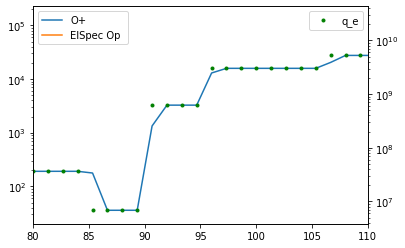

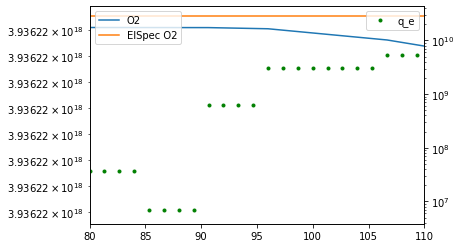

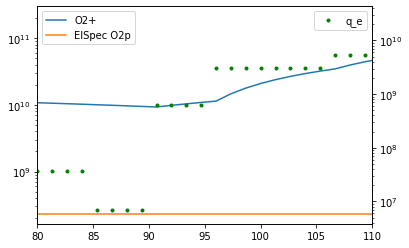

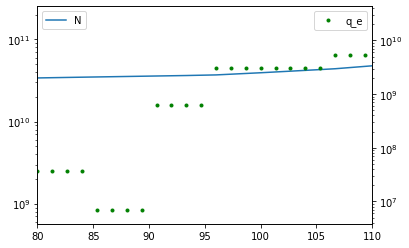

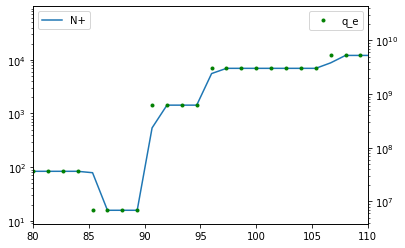

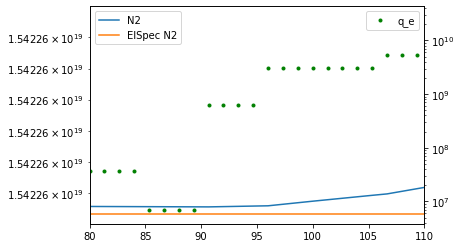

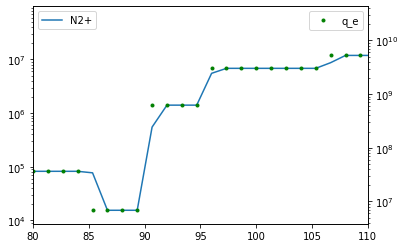

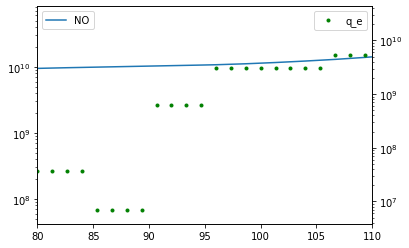

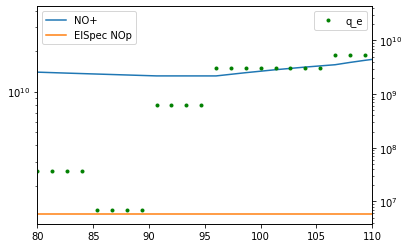

In [6]:
for h, i in enumerate(res):
    #if h < 20: continue
    print(z_model[h])
    for c in model.all_species:
        plt.figure()
        plt.plot(i.t, i.y[c.c_ID, :], label = c.name)
        if c == model.e  : plt.plot(ts, con["ne" ][h, :], label = 'ElSpec ne')
        if c == model.N2 : plt.plot(ts, con["iri"][h, 3], label = 'ElSpec N2')
        if c == model.O2 : plt.plot(ts, con["iri"][h, 4], label = 'ElSpec O2')
        if c == model.O  : plt.plot(ts, con["iri"][h, 5], label = 'ElSpec O ')
        if c == model.NOp: plt.plot(ts, con["iri"][h, 7], label = 'ElSpec NOp')
        if c == model.O2p: plt.plot(ts, con["iri"][h, 8], label = 'ElSpec O2p')
        if c == model.Op : plt.plot(ts, con["iri"][h, 9], label = 'ElSpec Op ')
        plt.legend(loc = 2)
        plt.yscale('log')
        ax2 = plt.gca().twinx()
        ax2.plot(ts, e_prod[:, 0], '.', color = 'green', label = 'q_e')
        ax2.set_yscale('log')
        ax2.legend(loc = 1)
        plt.xlim([80, 110])
        #for t in ts: plt.axvline(t, alpha = 0.1)
    break

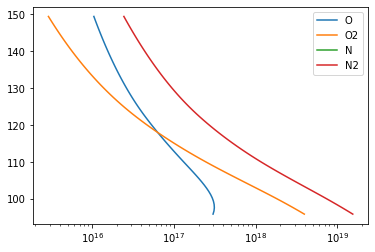

In [7]:
plt.figure()
plt.plot(O [:, 0], z_model, label = 'O')
plt.plot(O2[:, 0], z_model, label = 'O2')
plt.plot(N [:, 0], z_model, label = 'N')
plt.plot(N2[:, 0], z_model, label = 'N2')
plt.xscale('log')
plt.legend()

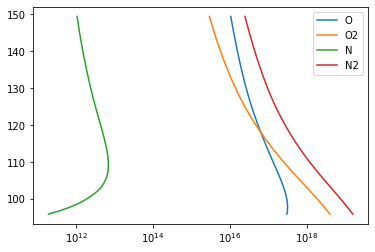

In [8]:
plt.figure()
plt.plot(O [:, -1], z_model, label = 'O')
plt.plot(O2[:, -1], z_model, label = 'O2')
plt.plot(N [:, -1], z_model, label = 'N')
plt.plot(N2[:, -1], z_model, label = 'N2')
plt.xscale('log')
plt.legend()

In [9]:
osstr = "/Applications/MATLAB_R2022b.app/bin/./matlab -sd "+\
          "\"/Users/ost051/Documents/PhD/ELSPEC-2022"+\
          "\" -batch \"ElSpecPlot()\" -nodisplay -nojvm"

os.system(osstr)


NameError: name 'os' is not defined

/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_40162/4225386099.py:26: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_40162/4225386099.py:37: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):


In [28]:
nN2,nO2,nO,nAr

(62, 10, 128)

/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_40162/4225386099.py:26: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_40162/4225386099.py:37: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):


Text(0.5, 1.0, 'Charged Species Stackplot at height index 20')

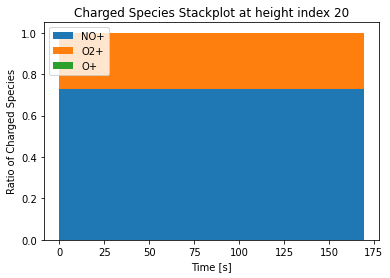

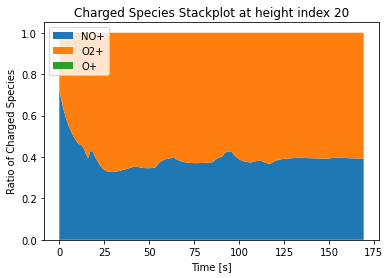

In [38]:
it0 = '/Users/ost051/Documents/PhD/ELSPEC-2022/test/ElSpec-iqt_IC_0.mat'
it6 = '/Users/ost051/Documents/PhD/ELSPEC-2022/test/ElSpec-iqt_IC_6.mat'
con = loadmat(it0)["ElSpecOut"]
n_model = con["iri"]
ne = con["ne"]
[Tn,Ti,Te,nN2,nO2,nO,nAr,nNOp,nO2p,nOp] = n_model.swapaxes(0, 1)
[nNOp,nO2p,nOp] = n_model[:, 7:, :].swapaxes(0,1)/np.sum(n_model[:, 7:, :], axis = 1)

h = 20
plt.figure()
plt.stackplot(ts, nNOp[h],nO2p[h],nOp[h],  \
              labels = ['NO+', 'O2+', 'O+'])
plt.xlabel('Time [s]')
plt.ylabel('Ratio of Charged Species')
plt.legend(loc = 2)
plt.title('Charged Species Stackplot at height index ' + str(h))

con = loadmat(it6)["ElSpecOut"]
n_model = con["iri"]
[Tn,Ti,Te,nN2,nO2,nO,nAr,nNOp,nO2p,nOp] = n_model.swapaxes(0, 1)
[nNOp,nO2p,nOp] = n_model[:, 7:, :].swapaxes(0,1)/np.sum(n_model[:, 7:, :], axis = 1)

h = 20
plt.figure()
plt.stackplot(ts, nNOp[h],nO2p[h],nOp[h],  \
              labels = ['NO+', 'O2+', 'O+'])
plt.xlabel('Time [s]')
plt.ylabel('Ratio of Charged Species')
plt.legend(loc = 2)
plt.title('Charged Species Stackplot at height index ' + str(h))